In [1]:
import torch
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# Image transformations
image_transforms = {
    # Train
    'train':
    transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize([0, 0, 0], [1, 1, 1])
    ]),
    # Test
    'test':
    transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0, 0, 0], [1, 1, 1])
    ]),
}

In [4]:
train_df = pd.read_csv('../GTSRB/Train.csv')
train_df = train_df[train_df['Path'].str[-6:-4].astype(int)==29]
train_df = train_df[(train_df.ClassId<=3)&(train_df.ClassId!=0)]
train_df.ClassId = train_df.ClassId - 1
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
599,114,118,10,11,104,108,0,Train/1/00001_00000_00029.png
629,71,67,6,6,65,61,0,Train/1/00001_00001_00029.png
659,74,70,7,6,68,64,0,Train/1/00001_00002_00029.png
689,164,170,15,14,150,156,0,Train/1/00001_00003_00029.png
719,63,64,5,6,58,59,0,Train/1/00001_00004_00029.png


In [5]:
test_df = pd.read_csv('../GTSRB/Test.csv')
test_df = test_df[(test_df.ClassId<=3)&(test_df.ClassId!=0)]
test_df.ClassId = test_df.ClassId - 1
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
1,42,45,5,5,36,40,0,Test/00001.png
23,32,33,5,5,27,28,2,Test/00023.png
24,59,65,5,6,54,60,0,Test/00024.png
34,58,59,6,6,53,54,1,Test/00034.png
36,34,36,5,6,29,31,2,Test/00036.png


In [6]:
class MyDataset(Dataset):
    def __init__(self, path, df, transforms):
        self.path = path
        self.df = df
        self.len = len(df)
        self.transforms = transforms
    def __len__(self):
        return self.len
    def __getitem__(self, index):
        im_path = self.df['Path'].iloc[index]
        img = cv2.imread(self.path+im_path)
        img = Image.fromarray(img)
        img = img.convert('RGB')
        img = self.transforms(img)
        label = self.df['ClassId'].iloc[index]
        return img, label

In [7]:
path = '../GTSRB/'
train_dataset = MyDataset(path, train_df, image_transforms['train'])
test_dataset = MyDataset(path, test_df, image_transforms['test'])

In [8]:
# Dataloader iterators, make sure to shuffle
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [9]:
class CNN(torch.nn.Module):
    
    #input for x is (3, 128, 128)
    
    def __init__(self):
        super(CNN, self).__init__()
        #layer output is (16, 64, 64)
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=11, stride=1, padding=5)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #layer output is (32, 32, 32)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #layer output is (64, 16, 16)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #fc layer
        self.fc1 = torch.nn.Linear(64 * 16 * 16, 32)    
        self.fc2 = torch.nn.Linear(32, 3)
        
    def forward(self, x):   
        #conv layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        #fc layer
        x = x.view(-1, 64 * 16 *16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
model = CNN().to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [12]:
n_epochs = 30
train_loss = []
train_acc = []
test_acc = []
for epoch in range(n_epochs):
    running_loss = 0
    running_correct = 0
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)
        # Generate predictions
        outputs = model(data)
        # Calculate loss
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
        # Loss and accuracy calc
        preds = torch.argmax(outputs, axis=1)
        running_loss += loss.item()
        running_correct += torch.sum(preds == targets.data)
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        preds = model(data)
        preds = torch.argmax(preds, axis=1)
        correct += torch.sum(preds==target.data)
    epoch_loss = running_loss/len(train_loader.dataset)
    epoch_acc = running_correct.float()/ len(train_loader.dataset)
    t_acc = correct.item()/len(test_loader.dataset)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_acc.append(t_acc)
print('Final Training Accuracy:', train_acc[-1])
print('Final Test Accuracy:', test_acc[-1])

Final Training Accuracy: tensor(0.8929, device='cuda:0')
Final Test Accuracy: 0.6682291666666667


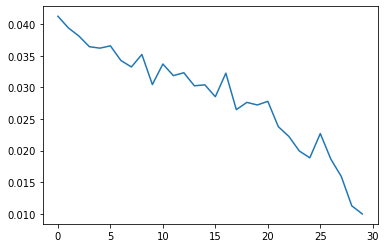

In [13]:
plt.plot(train_loss)

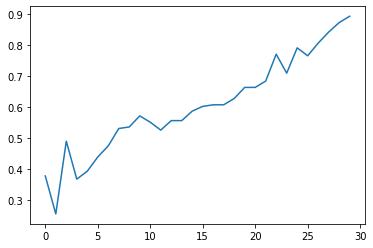

In [14]:
plt.plot(train_acc)

In [15]:
model.eval();

In [16]:
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    preds = model(data)
    preds = torch.argmax(preds, axis=1)
    correct += torch.sum(preds==target.data)
    
correct.item()/len(test_loader.dataset)

0.6682291666666667